In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import TTestIndPower

In [29]:
def perform_power_analysis(effect_size, alpha, nobs1, desired_power, sample_sizes=None):
    """
    Выполняет анализ мощности и визуализирует зависимость мощности от размера выборки.
    
    Параметры:
      effect_size: Размер эффекта (Cohen's d)
      alpha: Уровень значимости
      nobs1: Размер выборки для группы A (предполагается равенство групп)
      desired_power: Желаемая мощность теста (например, 0.8 для 80%)
      sample_sizes: (Опционально) массив значений размера выборки для построения графика.
                    Если не задан, используется диапазон от 100 до 2000 с шагом 50.
    """
    analysis = TTestIndPower()
    
    current_power = analysis.power(effect_size=effect_size, nobs1=nobs1, alpha=alpha, ratio=1.0)
    print(f"Мощность теста при n = {nobs1}: {current_power:.4f}")
    
    required_n = analysis.solve_power(effect_size=effect_size, power=desired_power, alpha=alpha, ratio=1.0)
    print(f"Требуемый размер выборки на группу для мощности {desired_power*100:.0f}%: {required_n:.0f}")
    
    if sample_sizes is None:
        sample_sizes = np.arange(100, 2000, 50)
    
    powers = analysis.power(effect_size=effect_size, nobs1=sample_sizes, alpha=alpha, ratio=1.0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(sample_sizes, powers, marker='o', linestyle='-', label='Мощность теста')
    plt.axhline(desired_power, color='red', linestyle='--', label=f'Желаемая мощность: {desired_power}')
    plt.xlabel('Размер выборки на группу')
    plt.ylabel('Мощность теста')
    plt.title("Зависимость мощности теста от размера выборки")
    plt.legend()
    plt.grid(True)
    plt.show()

In [30]:
np.random.seed(42)

In [31]:
n_A, n_B = 1000, 1000
group_A = np.random.normal(loc=50, scale=10, size=n_A)
group_B = np.random.normal(loc=55, scale=10, size=n_B)


In [32]:
def bootstrap_statistic(data, statistic_func=np.mean, n_bootstrap=10000, random_state=42):
    rng = np.random.default_rng(random_state)
    boot_stats = np.empty(n_bootstrap)
    n = len(data)
    for i in range(n_bootstrap):
        sample = rng.choice(data, size=n, replace=True)
        boot_stats[i] = statistic_func(sample)
    return boot_stats

In [33]:
def percentile_ci(boot_stats, ci=95):
    lower = np.percentile(boot_stats, (100-ci)/2)
    upper = np.percentile(boot_stats, 100 - (100-ci)/2)
    return lower, upper


In [34]:
boot_means_A = bootstrap_statistic(group_A, np.mean)
boot_means_B = bootstrap_statistic(group_B, np.mean)

In [35]:
ci_A = percentile_ci(boot_means_A)
ci_B = percentile_ci(boot_means_B)

In [36]:
boot_diff = boot_means_B - boot_means_A
ci_diff = percentile_ci(boot_diff)

Двухсторонний тест: берем минимальную вероятность от boot_diff <= 0 или boot_diff >= 0 и умножаем на 2

In [37]:
p_value_boot = 2 * min(np.mean(boot_diff <= 0), np.mean(boot_diff >= 0))

In [38]:
def cohen_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / (nx+ny-2))
    return (np.mean(x) - np.mean(y)) / pooled_std

In [39]:
effect_size = cohen_d(group_B, group_A)

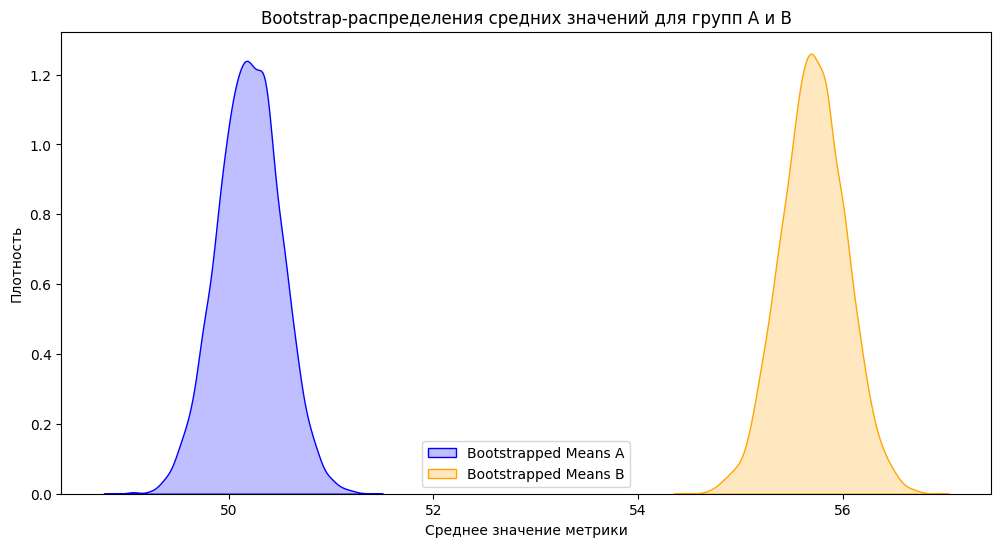

In [40]:
plt.figure(figsize=(12, 6))
sns.kdeplot(boot_means_A, label='Bootstrapped Means A', fill=True, color='blue')
sns.kdeplot(boot_means_B, label='Bootstrapped Means B', fill=True, color='orange')
plt.xlabel('Среднее значение метрики')
plt.ylabel('Плотность')
plt.title('Bootstrap-распределения средних значений для групп A и B')
plt.legend()
plt.show()

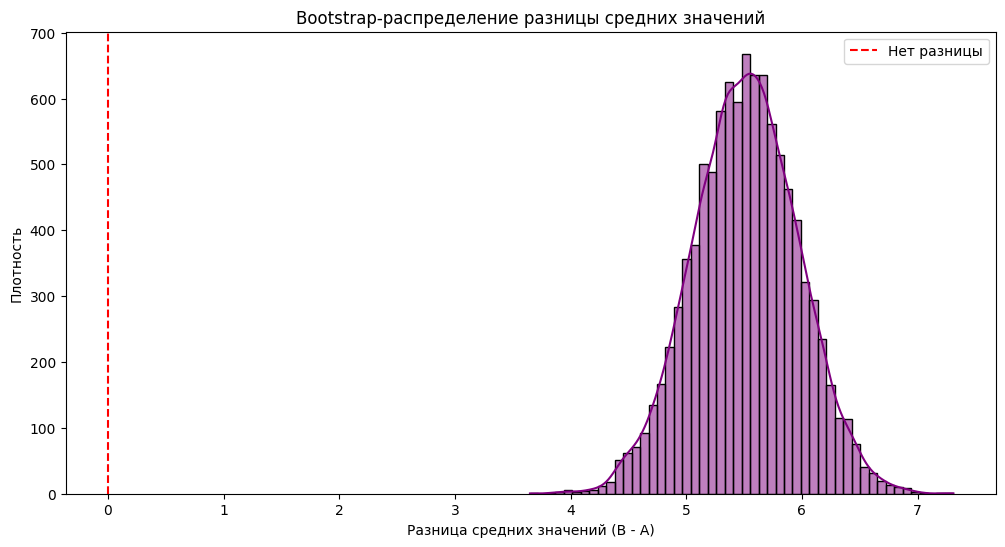

In [41]:
plt.figure(figsize=(12, 6))
sns.histplot(boot_diff, bins=50, kde=True, color='purple')
plt.axvline(0, color='red', linestyle='dashed', label='Нет разницы')
plt.xlabel('Разница средних значений (B - A)')
plt.ylabel('Плотность')
plt.title('Bootstrap-распределение разницы средних значений')
plt.legend()
plt.show()


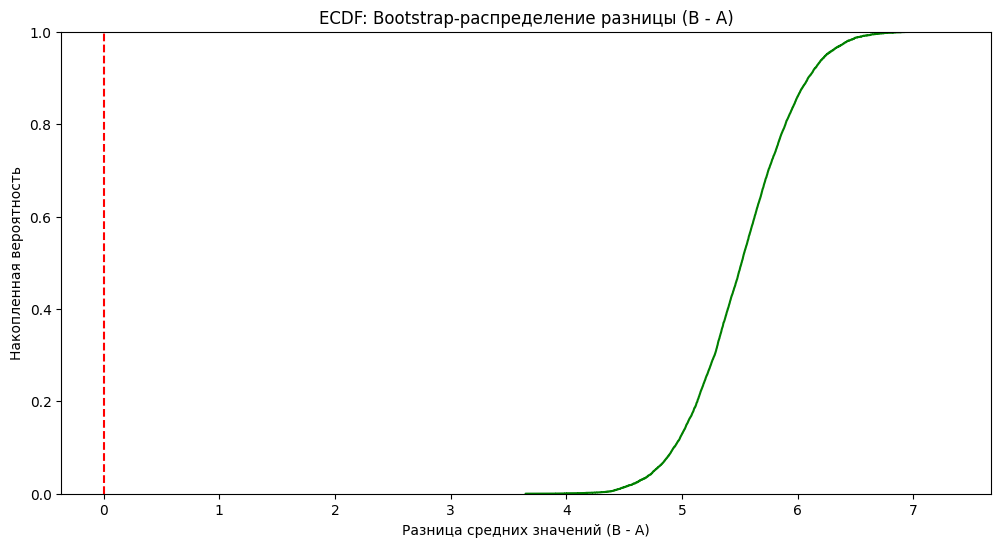

In [42]:
plt.figure(figsize=(12, 6))
sns.ecdfplot(boot_diff, color='green')
plt.axvline(0, color='red', linestyle='dashed')
plt.xlabel('Разница средних значений (B - A)')
plt.ylabel('Накопленная вероятность')
plt.title('ECDF: Bootstrap-распределение разницы (B - A)')
plt.show()

Мощность теста при n = 1000: 1.0000
Требуемый размер выборки на группу для мощности 80%: 64


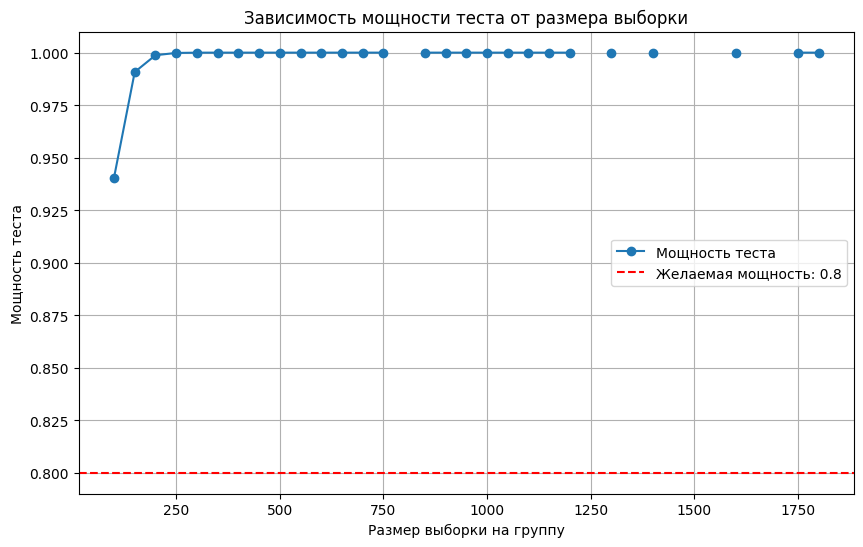

In [43]:
perform_power_analysis(effect_size=0.5, alpha=0.05, nobs1=1000, desired_power=0.8)

In [44]:
print("95% доверительный интервал для Group A (среднее): [{:.2f}, {:.2f}]".format(ci_A[0], ci_A[1]))
print("95% доверительный интервал для Group B (среднее): [{:.2f}, {:.2f}]".format(ci_B[0], ci_B[1]))
print("95% доверительный интервал для разницы (B - A): [{:.2f}, {:.2f}]".format(ci_diff[0], ci_diff[1]))
print("Bootstrap p-value: {:.4f}".format(p_value_boot))
print("Effect size (Cohen's d): {:.4f}".format(effect_size))

if ci_diff[0] > 0:
    print("🎉 Группа B значительно лучше A!")
elif ci_diff[1] < 0:
    print("❌ Группа B значительно хуже A.")
else:
    print("🤔 Различие между группами A и B незначительное.")

95% доверительный интервал для Group A (среднее): [49.58, 50.80]
95% доверительный интервал для Group B (среднее): [55.09, 56.33]
95% доверительный интервал для разницы (B - A): [4.62, 6.40]
Bootstrap p-value: 0.0000
Effect size (Cohen's d): 0.5580
🎉 Группа B значительно лучше A!
